# Part 2 : Histogram manipulation and equalisation

In this part of the TP, we are going to look at histogram equalisation. First, let us load the necessary packages and redefine some helper functions. Note that in this part of TP, you can use the plt.imshow function, since we are not interested in the aliasing effects which might occur.

### Your task

In the lab work, you must fill in the code in the places marked FILL IN CODE, or answer the written questions directly on the notebook.

In [0]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color

def read_image(file_name):
    img_color = imageio.imread(file_name)
    # NOTE : color.rgb2gray converts to the range 0 ... 1
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

(420, 570)

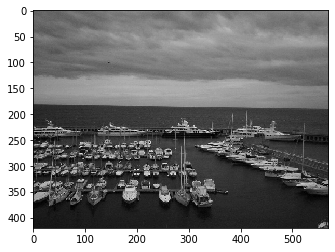

In [0]:
file_dir = 'images/'
file_name = 'boat'
file_ext = '.png'
img_gray,_ = read_image(file_dir+file_name+file_ext)
display_image(img_gray)
img_gray.shape

As you can see, this image has pretty bad contrast : it is difficult to see in it. Now, display the histogram of this image to show this (see the intro to images notebook for help)

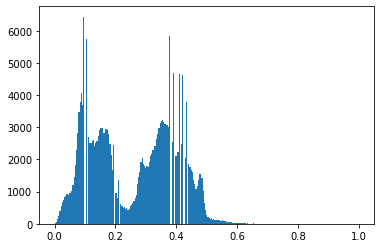

In [0]:
_ = plt.hist(img_gray.flatten(), bins=np.linspace(0,1,256))

You will notice that the histogram is not very well spread out over the whole range of the image. We are going to correct this in this part of the TP, by imposing a __uniform histogram__ on the image.

Firstly, calculate the cumulative histogram $H$ of the image and display it (use the np.cumsum function).

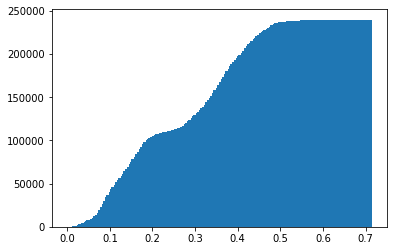

In [0]:
_=plt.hist(img_gray.flatten(), bins = 256, cumulative = True)

## Histogram equalisation

Now, if we apply the cumulative histogram $H$ as a contrast change, then we are imposing a uniform histogram on the image (see the lesson slides). A contrast change means we do not change the order of the __values__ of the pixels. We are going to use $H$ as a type of lookup table to find the new values of the image.

In practice, this can be done with the following method :

- normalise the cumulative histogram such that the largest value is 1.0. This will map the final image to the interval $0, \dots, 1$ (you will still have a discrete list of values, but floating point ones)
- convert the image grey-levels back to the interval $\{0, \dots 255\}$ as int values (use the n. This will allow us to use these values as indices in H
- apply the cumulative histogram to the values of the image pixels

Implement this algorithm now in a function ``equalize_histogram``. __Note__ In the ``np.histogram`` function, the histogram values have one less element than the histogram bins

In [0]:
def equalize_histogram(img_in):
    image=np.asarray(img_in*255, dtype="uint8" )
    flat = image.flatten()
    histogram = np.zeros(256)

    for pixel in image:
        histogram[pixel] += 1
       
    a = iter(histogram)
    b = [next(a)]
    for i in a:
        b.append(b[-1] + i)
    cs= np.array(b)

    nj = (cs - cs.min()) * 255
    N = cs.max() - cs.min()

    # re-normalize the cdf
    cs = nj / N
    cs = cs.astype('uint8')
    img_new = cs[flat]

    img_equalise=np.reshape(img_new, image.shape)

    return img_equalise/255.

Carry out the algorithm on the input image and display the image. Is the result better ?

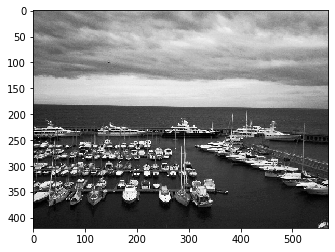

In [0]:
img_gray_equalise = equalize_histogram(img_gray)
display_image(img_gray_equalise)

Now, display both the histogram and cumulative histogram of the equalised image

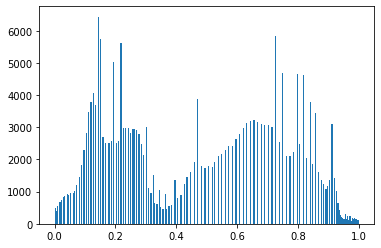

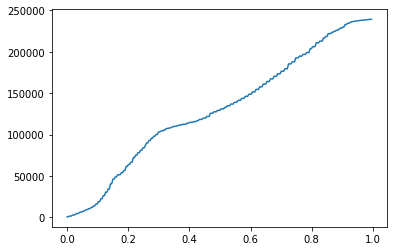

In [0]:
hist_vals, hist_bins,_ = plt.hist(img_gray_equalise.flatten(), bins=np.linspace(0,1,255))
plt.figure()
plt.plot(hist_bins[:-1],hist_vals.cumsum())

__Questions__ Is the histogram of the equalised image perfectly uniform (flat) ? Why is this the case ?

__Answer__

**Histogram equalization** is a method in image processing of contrast adjustment using the image's histogram.This method usually increases the global contrast of many images, especially when the usable data of the image is represented by close contrast values. Through this adjustment, the intensities can be better distributed on the histogram. This allows for areas of lower local contrast to gain a higher contrast. Histogram equalization accomplishes this by effectively spreading out the most frequent intensity values. 

**Histogram equalization** was initially developed by assuming continuous random variables. If the original image has intensities modeled as a continuous random variable **𝑋** with pdf $𝑝_𝑥(𝑥)$, and the HEQ image result's intensities as a continuous random variable **𝑌** with **PDF** $𝑝_𝑦(𝑦)$, then $𝑝_𝑦(𝑦)$ will be a uniform distribution, if we transform the random variable **𝑋** by its own CDF, **𝑇**. That is, **𝑌** will be a uniformly distributed continuous random variable if we set **𝑌=𝑇(𝑋)**. However, this is for the continuous case. For real images that are discrete, we are estimating a discrete CDF **𝑇** from coarse quantization levels, and applying it to a specific number of pixel values. This is why we will not get a perfectly uniform histogram result. Theory proves equalization for a continuous case, while in practice, we are dealing with discrete and quantized images and imperfect CDF estimation no less.

In Other words,If you make an **image histogram**, you are just measuring the popularity of all pixel values from say, 0 to 255. If all pixel values that take on a value of 0, are equal to the number of pixels that take on a value of 255, are equal to the number of pixels taking on a value of 123, (greyish), etc etc, then the histogram is an equalized histogram because all pixel-popularity measures are the same.

However not all images have this same spread. If you take a picture of a scene with the sun photo-bombing it in the background at noon, most of your pixels live around the 255 area, because the sun has made most pixels white, even if they were not white to begin with.

In this case, the histogram will be heavily skewed to the right. Now, the number of pixels that are white, is NOT equal to the number of grey pixels, or the number of black pixels, etc etc.

So in **histogram equalization**, this we force all the pixels to take on values, but in that case we have no guarantee that it will correspond in some form to the original image. This why you might not see a properly uniform distribution after equalization. Histogram equalization will try to make the PDF as uniform as possible, while at the same time respecting the original properties of the image.

### Colour images

Let us try to apply our algorithm to a colour image. First, let's read the image and display it

(761, 1142, 3)

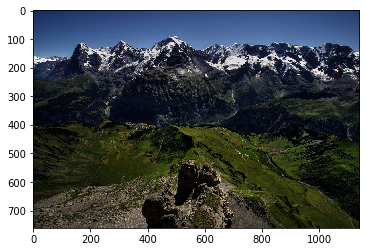

In [0]:
file_dir = 'images/'
file_name = 'alps_contrast'
file_ext = '.png'
_,img_color = read_image(file_dir+file_name+file_ext)
display_image(img_color)
img_color.shape

Now, create a function ``equalize_histogram_color`` which uses your grey-level function to carry out colour histogram equalisation in each colour channel independently, and display the output image. Careful to

- normalise the input range to $0, \dots, 1$ for each channel when processing it
- put the output range back to $0, \dots, 255$ when displaying.

To view the result better, you can write it to a file.

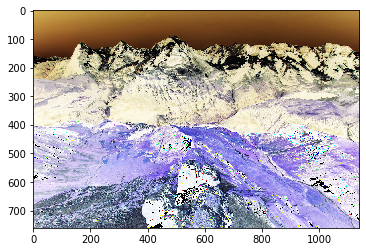

In [0]:
def equalize_histogram_color(img_color):
    img_color_equalized=np.zeros(img_color.shape)
    for z in range(img_color.shape[2]):
       img_color_equalized[:,:,z]=equalize_histogram(img_color[:,:,z])
    # FILL IN CODE
    return img_color_equalized


img_color_equalized = equalize_histogram_color(img_color)
display_image(255.0 * img_color_equalized)

write_image(img_color_equalized,file_name+'_equalised.png')

__Question__ Do you think this result looks right ? What may be wrong in our approach ? What could be a solution to this ?

__Answer__

**Histogram equalization** is a non-linear process. Channel splitting and equalizing each channel separately is not the proper way for equalization of contrast. Equalization involves Intensity values of the image not the color components. So for a simple RGB color image, **Histogram equalization** should not be applied individually **on each channel**. Rather, it should be applied such that intensity values are equalized without disturbing the color balance of the image. So, the first step is to convert the color space of the image from RGB into one of the color spaces which separate intensity values from color components. Some of these are:

    HSV/HLS
    YUV
    YCbCr

Convert the image from RGB to one of the above mentioned color spaces. YCbCr is preferred as it is designed for digital images. Perform HE of the intensity plane Y. Convert the image back to RGB.

3


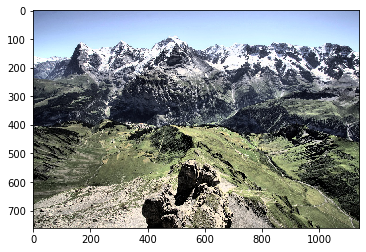

In [0]:
import cv2
import os

def hisEqulColor(img):
    ycrcb=cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)
    channels=cv2.split(ycrcb)
    print (len(channels))
    cv2.equalizeHist(channels[0],channels[0])
    cv2.merge(channels,ycrcb)
    cv2.cvtColor(ycrcb,cv2.COLOR_YCR_CB2BGR,img)
    return img


fname=file_dir+file_name+file_ext
img=cv2.imread(fname)

cv2.imwrite('img.jpg', img)
img2=hisEqulColor(img)
cv2.imwrite('img2.jpg',img2)
_,img_color = read_image('img2.jpg')
display_image(img_color)
